## Scenario Descriptions

### CAGE Challenge 2

Your firm has been contracted by Florin to trial your new autonomous defence agents. Florin have given your agent authority to defend the computer network at one of their manufacturing plants. The network, shown in Figure 1, contains a user network for staff, an enterprise network, and an operational network which contains the key manufacturing and logistics servers. The defence agent receives an alert feed from Florin’s existing monitoring systems. It can run detailed analyses on hosts, then remove malicious software if found. If an attacker is too well established on a host to be removed, the host can be restored from a clean backup. Finally, the defence agent can deceive attackers by creating decoy services.

The network owner has undertaken an evaluation of the factory systems and contracted your firm to defend these systems according to the following criteria:

Maintain the critical operational server to ensure information about the new weapon system is not revealed to Guilder and the production and delivery of the new weapon system remains on schedule.
Where possible, maintain enterprise servers to ensure day-to-day operations of the manufacturing plant are not disrupted or revealed.”

Subnet 1 consists of user hosts that are not critical. \
Subnet 2 consists of enterprise servers designed to support the user activities on Subnet 1. \
Subnet 3 contains the critical operational server and three user hosts.

<img src="https://github.com/cage-challenge/cage-challenge-2/raw/main/images/figure1.png">

The effect of each action on the state of a targeted host is summarized with the diagram.

<img src="https://github.com/cage-challenge/cage-challenge-2/raw/main/images/figure2.png" caption="State Diagram">

### Appendix - Action Sets

Blue Action Sets
    
| Action     | Purpose                                                                                                                                                                                                                                                 | Parameters                                                                    | Output                                 |
|:-----------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------|:---------------------------------------|
| Monitor | Collection of information about flagged malicious activity on the system\. Corresponds to action ID 1: Scan in the OpenC2 specification[^3]\.                                                                                                           | None *\(Note: This action occurs automatically if another action is chosen\)* | Network connections and associated processes that are identified as malicious\. |
| Analyse | Collection of further information on a specific host to enable blue to better identify if red is present on the system\. Corresponds to action ID 30: Investigate in the OpenC2 specification\.                                                         | Hostname                                                                      | Information on files associated with recent alerts including signature and entropy\.  |
| DecoyApache, DecoyFemitter, DecoyHarakaSMPT, DecoySmss, DecoySSHD, DecoySvchost, DecoyTomcat | Setup of a decoy service (as specified by the action name) on a specified host\. Green agents do not access these services, so any access is a clear example of red activity\.                                                                                                            | Hostname                                                                | An alert if the red agent accesses the new service\. |
| Remove | Attempting to remove red from a host by destroying malicious processes, files and services\. This action attempts to stop all processes identified as malicious by the monitor action\. Corresponds to action ID 10: Stop in the OpenC2 specification\. | Hostname                                                                      | Success/Failure |
| Restore | Restoring a system to a known good state\. This has significant consequences for system availability\. This action punishes Blue by \-1\. Corresponds to action ID 23: Restore in the OpenC2 specification\.                                            | Hostname                                                                      | Success/Failure  |

Red Action Sets
| Action     | Purpose                                                                                                                                                    | Parameters       | Output                                 |
|:-----------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------|:---------------------------------------|
| Discover Remote Systems | ATT&CK[^4] Technique T1018 Remote System Discovery\. Discovers new hosts/IP addresses in the network through active scanning using tools such as ping\.    | Subnet           | IP addresses in the chosen subnet from hosts that respond to ping |
| Discover Network Services | ATT&CK Technique T1046 Network Service Scanning. Discovers responsive services on a selected host by initiating a connection with that host\.              | Subnet           | Ports and service information |
| Exploit Network Services | ATT&CK Technique T1210 Exploitation of Remote Services\. This action attempts to exploit a specified service on a remote system\.                          | IP Address, Port | Success/Failure <br /> Initial recon of host if successful. |
| Escalate | ATT&CK Tactic TA0004 Privilege Escalation\. This action escalates the agent’s privilege on the host\.                                                      | Hostname         | Success/Failure <p> Internal information now available due to increased access to the host |
| Impact | ATT&CK Technique T1489 Service Stop\. This action disrupts the performance of the network and fulfils red’s objective of denying the operational service\. | Hostname         | Success/Failure  |

[^3]: Open Command and Control \(OpenC2\), [https://openc2\.org/](https://openc2\.org/)

[^4]: MITRE ATT&CK, [https://attack\.mitre\.org/](https://attack\.mitre\.org/)

### Agents

- Rules-based agents
- Deep Reinforcement Learning agents

### Rule-based agents

- Blue
    - RandomAgent: Takes a random action or a test action based on the epsilon value
    - BlueReactRemoveAgent: Adds suspicious hosts to the host list if the monitor finds something and then it will remove the program(session)
    - BlueReactRestoreAgent: Similar steps but restore the host from a cleaned backup.
- Red
    - RedMeanderAgent: Explores the network one subnet at a time, seeking to gain privileged access to all hosts in a subnet before moving on to the next one, eventually arriving at the Operational Server.
    - B_lineAgent: Attempts to move straight to the Operational Server using prior knowledge of the network layout.

In [1]:
# %pip list

In [1]:
import inspect
import time
import os
from statistics import mean, stdev
import random
import collections
import numpy as np
from pprint import pprint

from CybORG import CybORG, CYBORG_VERSION

from CybORG.Shared import Observation

from CybORG.Agents import B_lineAgent, BlueReactRestoreAgent, BlueReactRemoveAgent, \
    RandomAgent, RedMeanderAgent, SleepAgent
from CybORG.Agents.MainAgent import MainAgent
from CybORG.Agents.MainAgent_cyborg_mm import MainAgent as MainAgent_cyborg_mm

from CybORG.Agents.Wrappers.ChallengeWrapper import ChallengeWrapper
from CybORG.Agents.Wrappers import EnumActionWrapper
from CybORG.Agents.Wrappers.FixedFlatWrapper import FixedFlatWrapper
from CybORG.Agents.Wrappers.IntListToAction import IntListToActionWrapper
from CybORG.Agents.Wrappers.OpenAIGymWrapper import OpenAIGymWrapper
from CybORG.Simulator.Scenarios.FileReaderScenarioGenerator import FileReaderScenarioGenerator

from CybORG.GameVisualizer.NetworkVisualizer import NetworkVisualizer
from CybORG.GameVisualizer.GameStateCollector import GameStateCollector
from CybORG.Mininet.MininetAdapter import MininetAdapter

/home/ubuntu/justinyeh1995/CASTLEGym/castle.3.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


path is: /home/ubuntu/justinyeh1995/CASTLEGym/CybORG/CybORG/env.py


## Visualization

- input 
    - Observation from Red and Blue
    - Action for Blue / Red?
    - link_diagram

Mouse over event oberservations 
Different Shape
Different State

In [2]:
MAX_EPS = 1
agent_name = 'Blue'
random.seed(0)
cyborg_version = CYBORG_VERSION
scenario = 'Scenario2'

def wrap(env):
    return ChallengeWrapper(env=env, agent_name='Blue')

def get_git_revision_hash() -> str:
    return subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()


In [3]:
def main_cyborg_minus_minus():
    cyborg_version = CYBORG_VERSION
    scenario = 'Scenario2_cyborg--'
    # commit_hash = get_git_revision_hash()
    commit_hash = "Not using git"
    # ask for a name
    name = "CASTLEgym"
    # ask for a team
    team = "CardiffUni"
    # ask for a name for the agent
    name_of_agent = "PPO + Greedy decoys"

    lines = inspect.getsource(wrap)
    wrap_line = lines.split('\n')[1].split('return ')[1]

    # Change this line to load your agent
    agent = MainAgent_cyborg_mm()

    print(f'Using agent {agent.__class__.__name__}, if this is incorrect please update the code to load in your agent')

    path = str(inspect.getfile(CybORG))
    path = path[:-7] + f'/Simulator/Scenarios/scenario_files/Scenario2.yaml'
    sg = FileReaderScenarioGenerator(path)

    print(f'using CybORG v{cyborg_version}, {scenario}\n')
    
    # game manager initialization
    game_state_manager = GameStateCollector(environment='emu')
    # mininet adapter initialization
    mininet_adapter = MininetAdapter()
    
    for num_steps in [10]:
        for red_agent in [B_lineAgent]:
            red_agent = red_agent()
            cyborg = CybORG(sg, 'emu', agents={'Red': red_agent})
            wrapped_cyborg = wrap(cyborg)

            # This intialisation information is coming from Cyborg
            blue_observation = wrapped_cyborg.reset()
            blue_action_space = wrapped_cyborg.get_action_space('Blue')

            # Getting intial red_observation
            red_observation=cyborg.get_observation('Red')
            red_action_space= cyborg.get_action_space('Red')

            red_agent_name: str = red_agent.__class__.__name__
            blue_agent_name: str = agent.__class__.__name__
            
            # Set up game_state_manager
            game_state_manager.set_environment(cyborg=cyborg,
                                               red_agent_name=red_agent_name,
                                               blue_agent_name=blue_agent_name,
                                               num_steps=num_steps)
            game_state_manager.reset()


            # Reset mininet adapter 
            mininet_adapter.set_environment(cyborg=cyborg)
            mininet_adapter.reset()

            mininet_blue_observation = blue_observation
            mininet_red_observation = red_observation

            # red_agent = red_agent()
            
            total_reward = []
            actions_list = []
            for i in range(MAX_EPS):
                r = []
                a = []
                
                # cyborg.env.env.tracker.render()
                for j in range(num_steps):                   
                    ########
                    # Blue #
                    ######## 
                    blue_observation = mininet_blue_observation
                    blue_observation = wrapped_cyborg.env.env.observation_change('Blue', blue_observation.data) if isinstance(blue_observation, Observation) else blue_observation
                    blue_observation = np.array(blue_observation, dtype=np.float32)
                    
                    blue_action = agent.get_action(blue_observation, blue_action_space)
                    blue_possible_actions = wrapped_cyborg.env.possible_actions[blue_action]
                    print("--> In main loop: Blue action using mininet_observation")
                    print(blue_possible_actions)
                    #######
                    # Red #
                    ####### 
                    red_observation = mininet_red_observation.data if isinstance(mininet_red_observation, Observation) else mininet_red_observation
                    red_action=red_agent.get_action(red_observation, red_action_space)
                    print("--> In main loop: Red action using mininet_observation")
                    print(red_action)
                    
                    # observation, rew, done, info = wrapped_cyborg.step(blue_action) # needed in plotting
                    
                    # r.append(rew)
                    # r.append(result.reward)
                    # a.append((str(cyborg.get_last_action('Blue')), str(cyborg.get_last_action('Red'))))

                    # Game manager store state
                    mininet_red_observation, red_reward = mininet_adapter.step(str(red_action), agent_type='Red')
 
                    mininet_blue_observation, blue_reward = mininet_adapter.step(str(blue_possible_actions), agent_type='Blue')

                    # pprint(mininet_adapter)
                    actions = {"Red": str(red_action), "Blue": str(blue_possible_actions)}
                    observations = {"Red": mininet_red_observation.data, "Blue": mininet_blue_observation.data}
                    
                    # Create state for this step
                    state_snapshot = game_state_manager.create_state_snapshot(actions, observations)

                    game_state_manager.store_state(state_snapshot, i, j)
                    print(f"===Step {j} is over===")
                # game manager reset
                agent.end_episode()
                total_reward.append(sum(r))
                actions_list.append(a)
                # observation = cyborg.reset().observation
                observation = wrapped_cyborg.reset()
                game_state_manager.reset()
                # mininet adapter reset
                mininet_adapter.reset()
        
        mininet_adapter.clean()
    print("=====Done=====")       
    return game_state_manager.get_game_state()

In [6]:
# %%capture
test_cyborg_minus_minus = main_cyborg_minus_minus()

Using agent MainAgent, if this is incorrect please update the code to load in your agent
using CybORG v3.1, Scenario2_cyborg--

env is: emu
Agent Interfaces are: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f6ae124d0c0>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f6ae124d180>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f6ae11b37c0>}


/home/ubuntu/justinyeh1995/CASTLEGym/castle.3.venv/lib/python3.10/site-packages/gym/utils/seeding.py:47: DeprecationWarning:

WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.



Agent Interfaces are: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f6ae1283820>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f6ae1283790>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f6ae12819f0>}
===Resetting===
Topology for file 'network_topology.yaml' created.
YAML file 'network_topology.yaml' created.
 lan1h1 ping -c 1 google.com
PING google.com (173.194.219.102) 56(84) bytes of data.
64 bytes from ya-in-f102.1e100.net (173.194.219.102): icmp_seq=1 ttl=53 time=13.6 ms

--- google.com ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 13.606/13.606/13.606/0.000 ms

--> In main loop: Blue action using mininet_observation
DecoyApache Enterprise0
--> In main loop: Red action using mininet_observation
DiscoverRemoteSystems 10.0.202.48/28
---> in MininetAdapter Red step
--> in MininetAdapter parse_action_string
DiscoverRemoteSystems 10.0.202.48/28
Red Discover Remote Syst

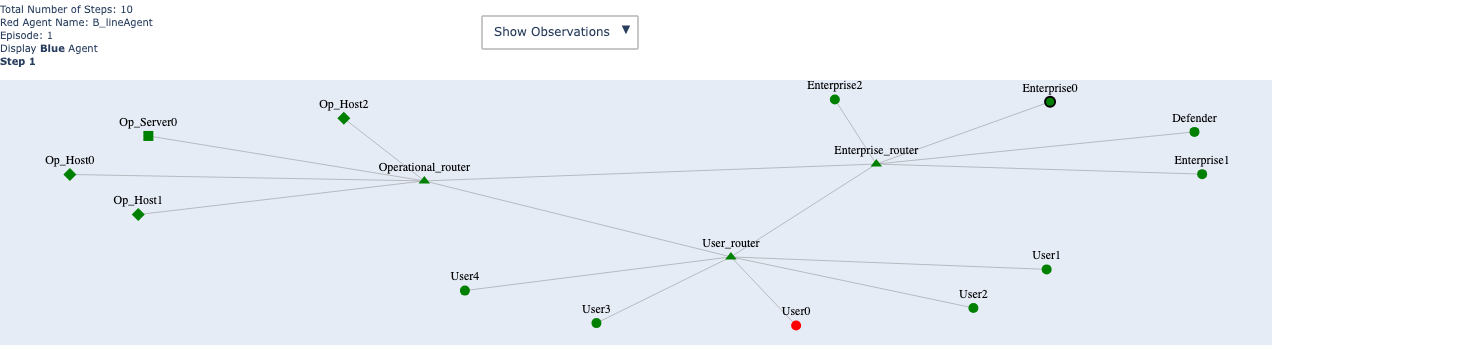

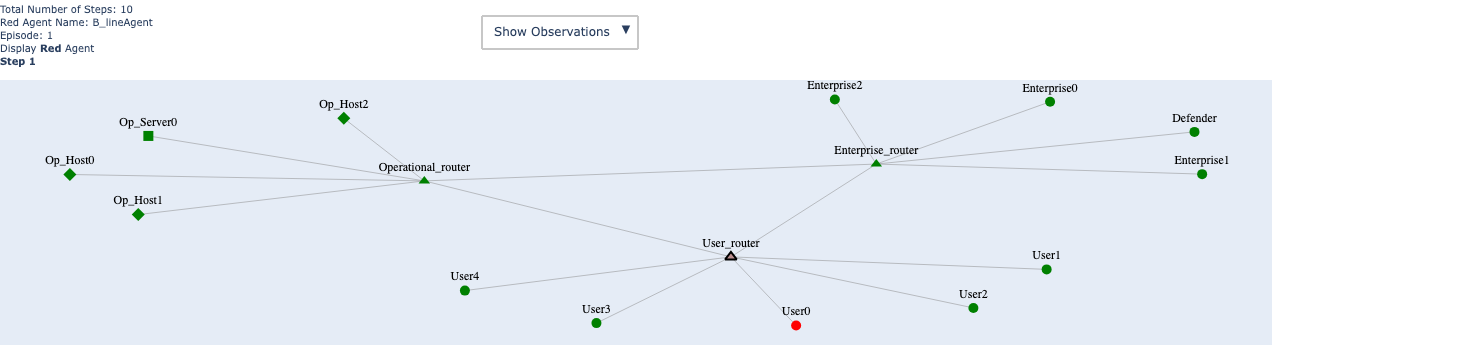

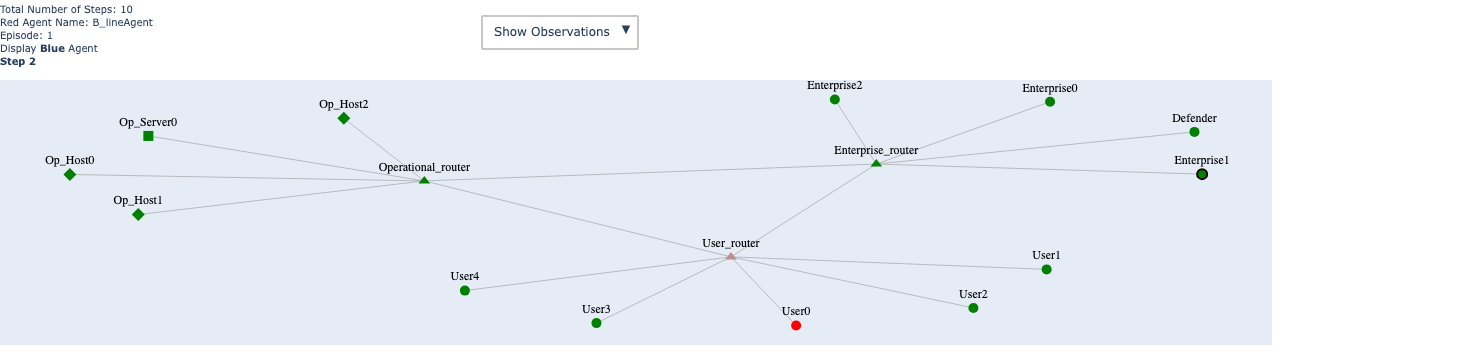

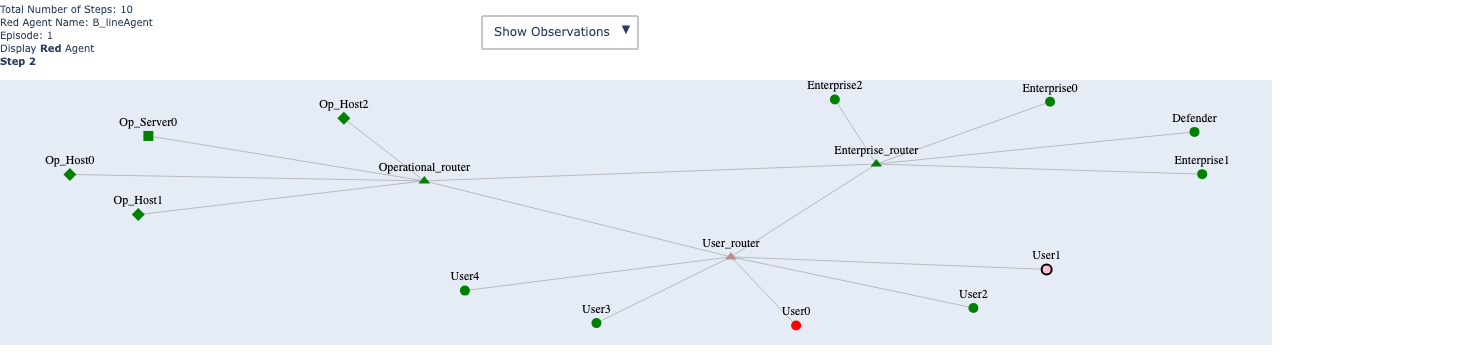

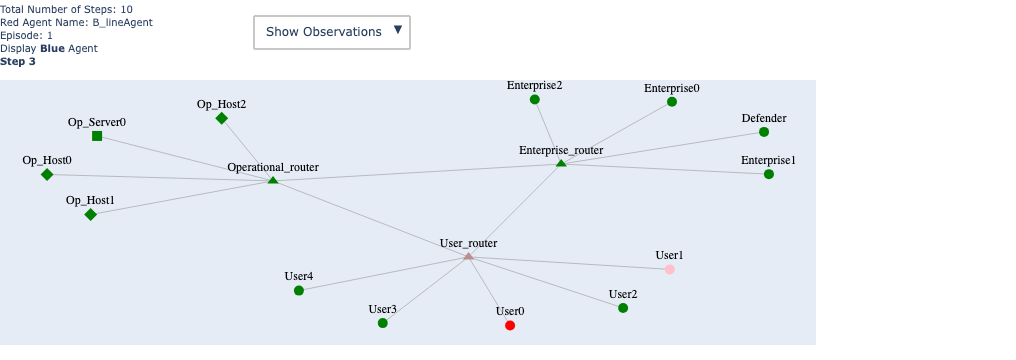

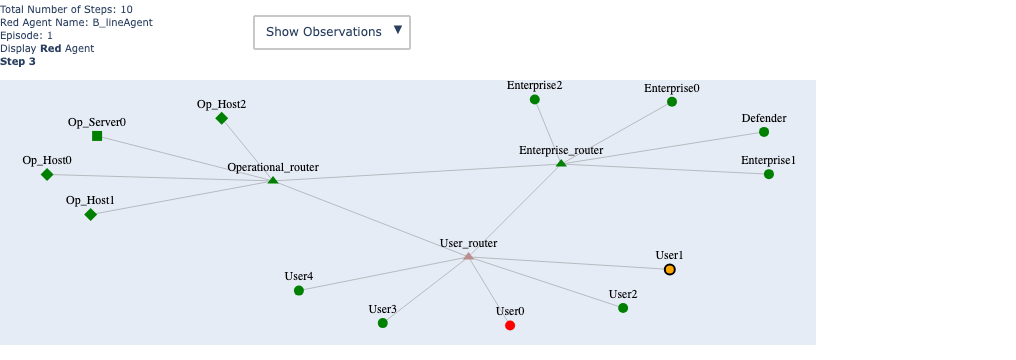

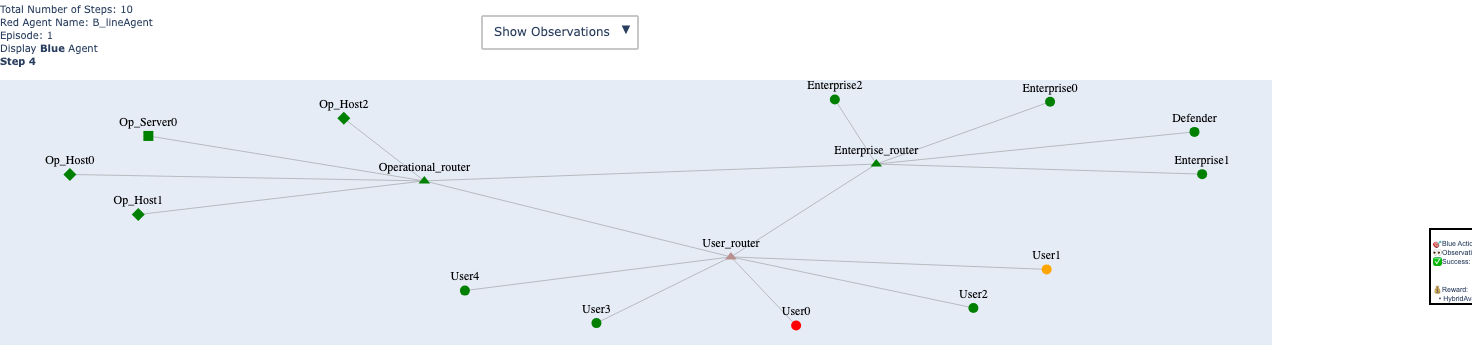

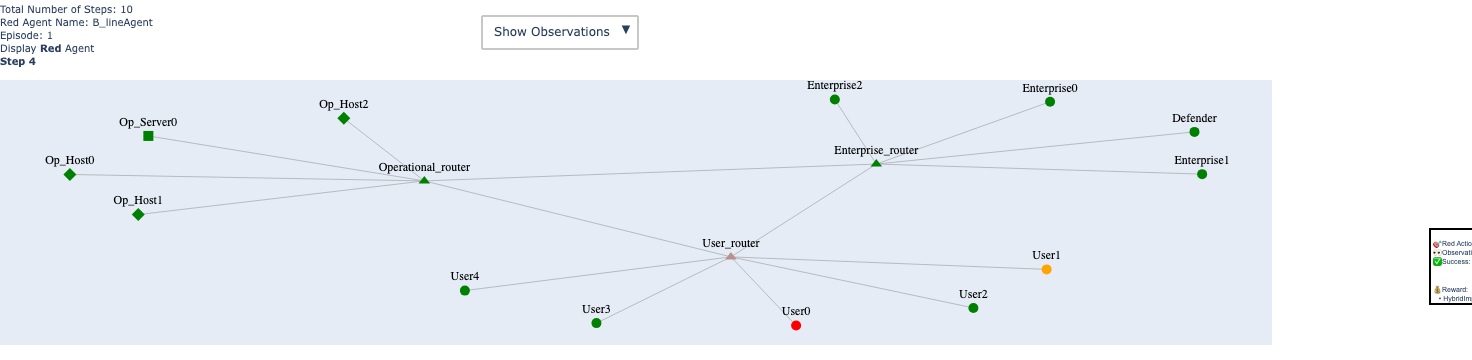

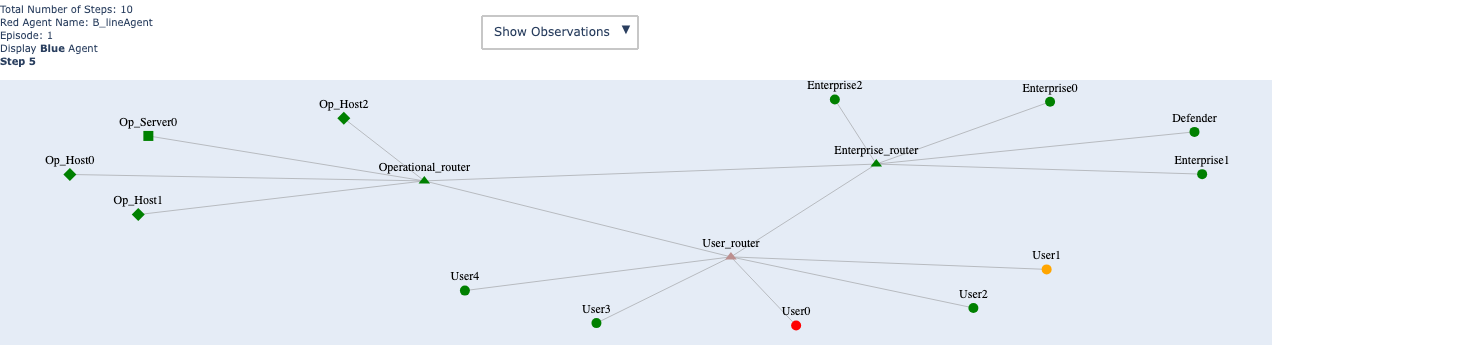

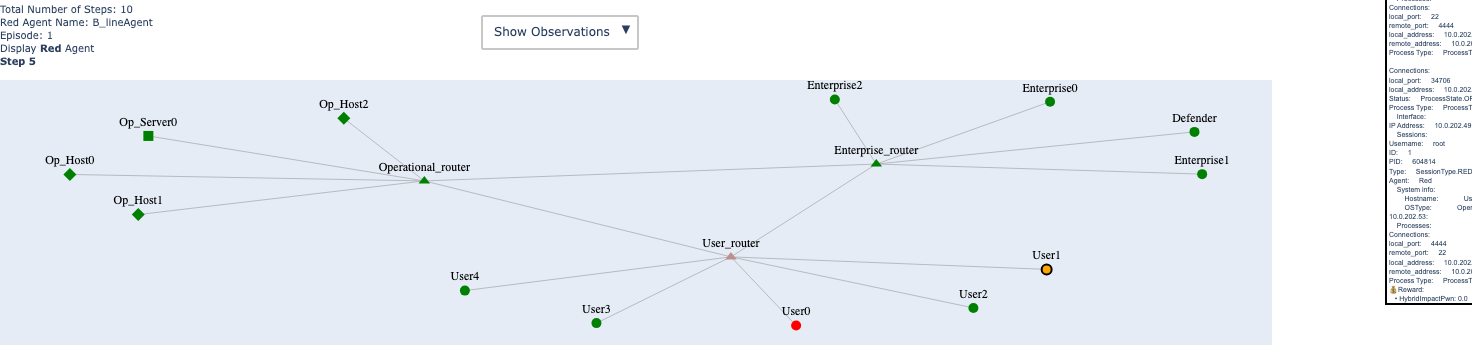

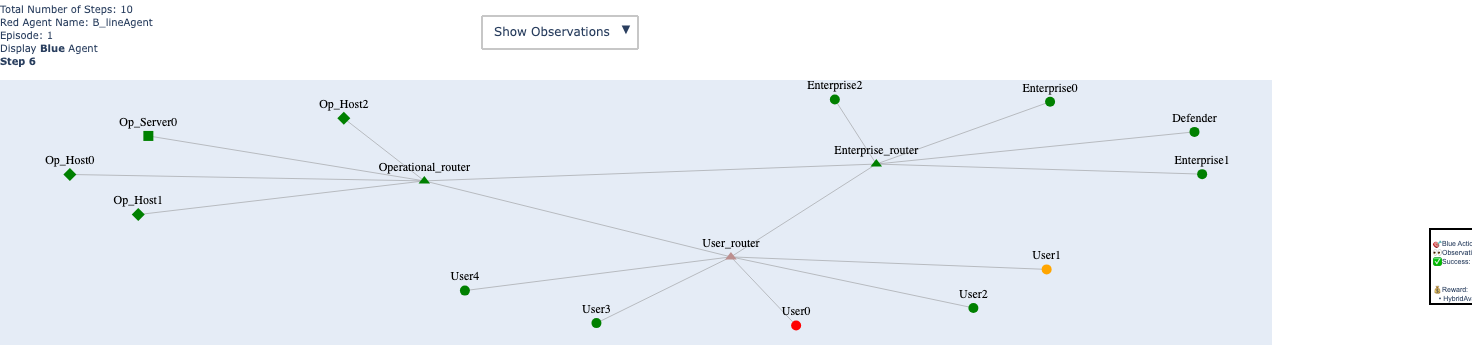

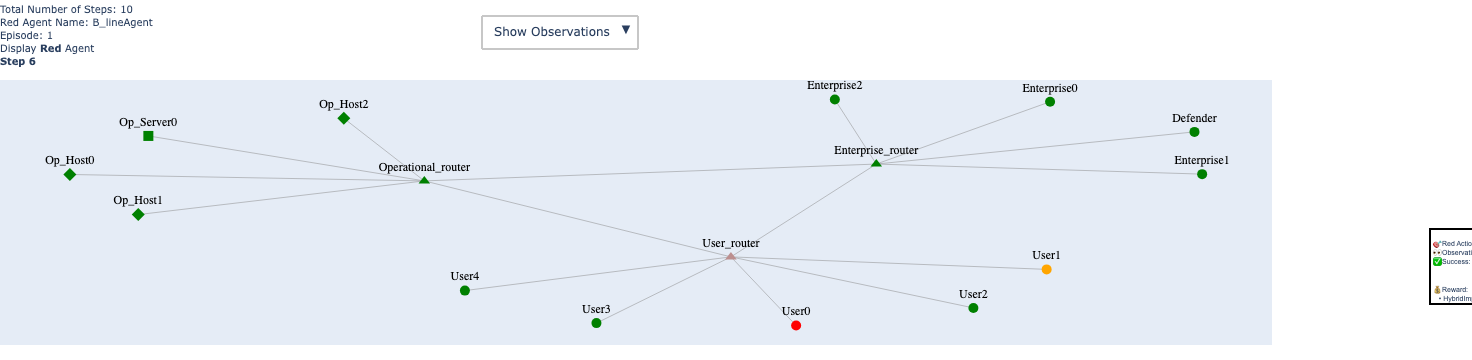

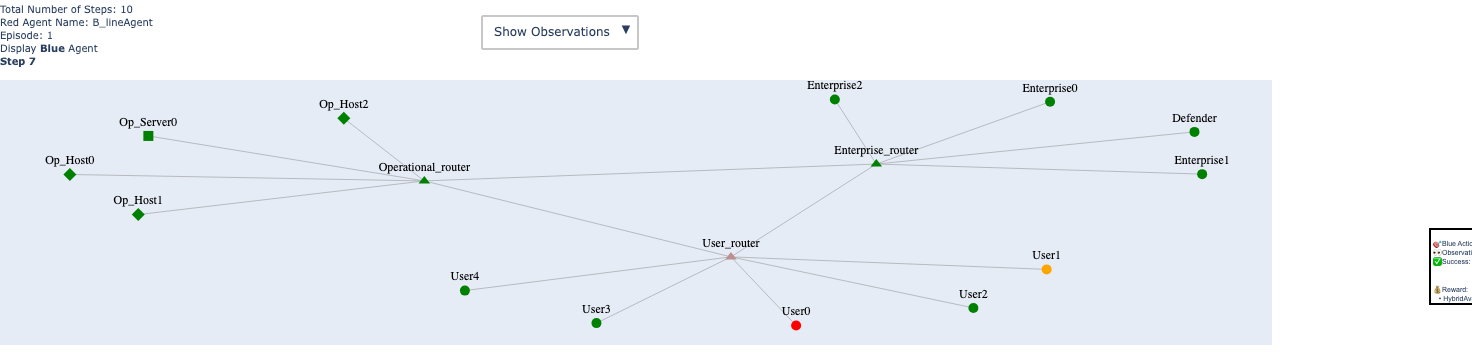

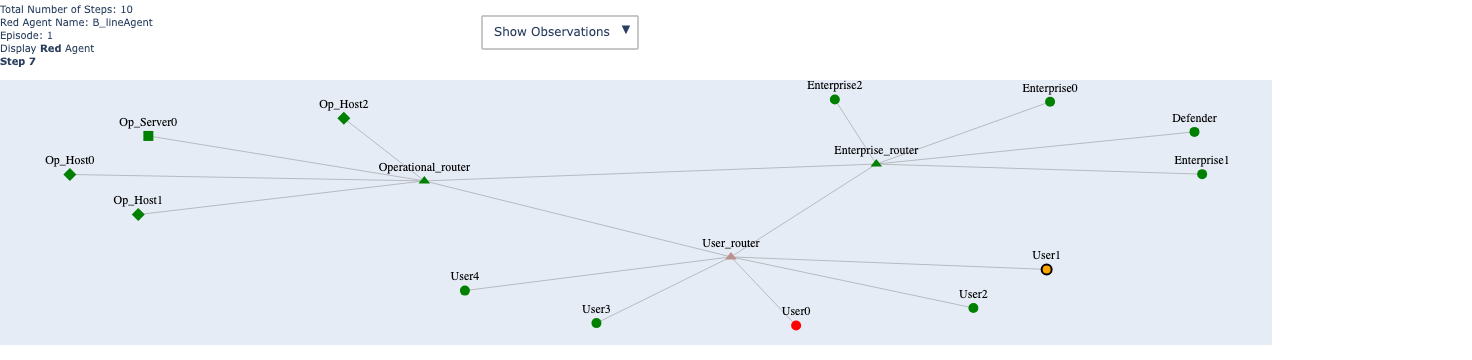

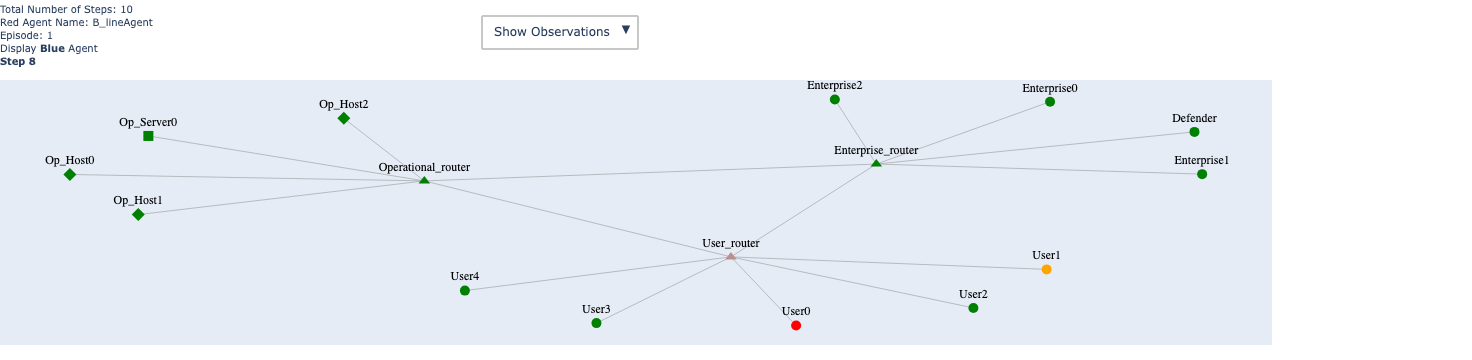

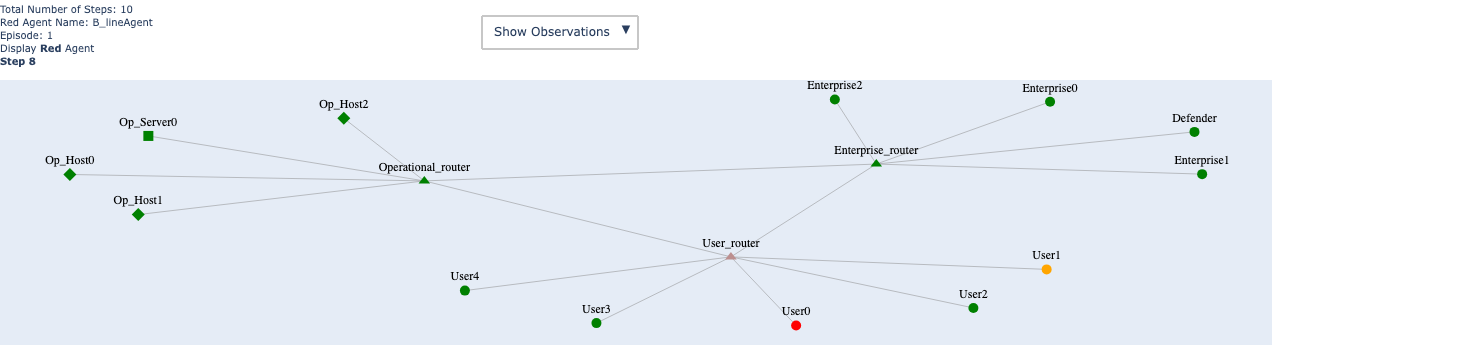

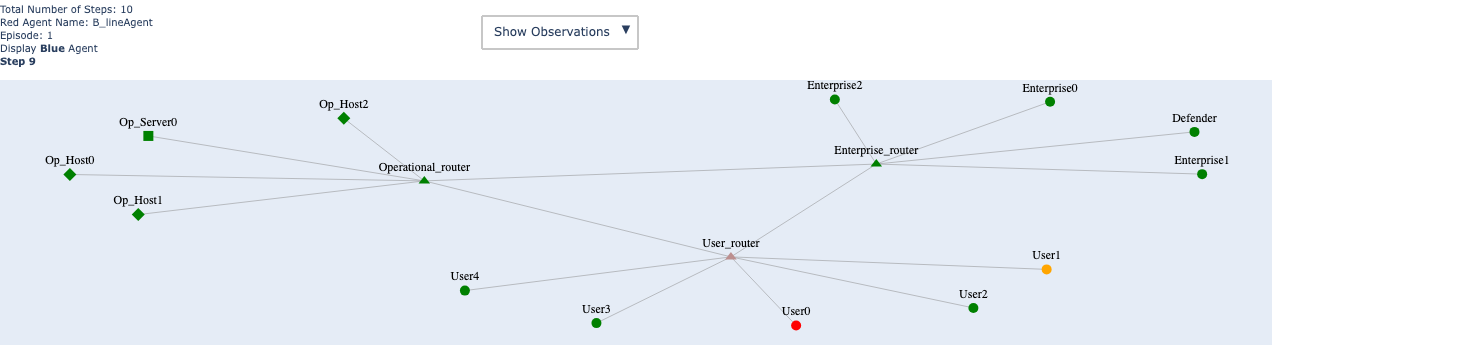

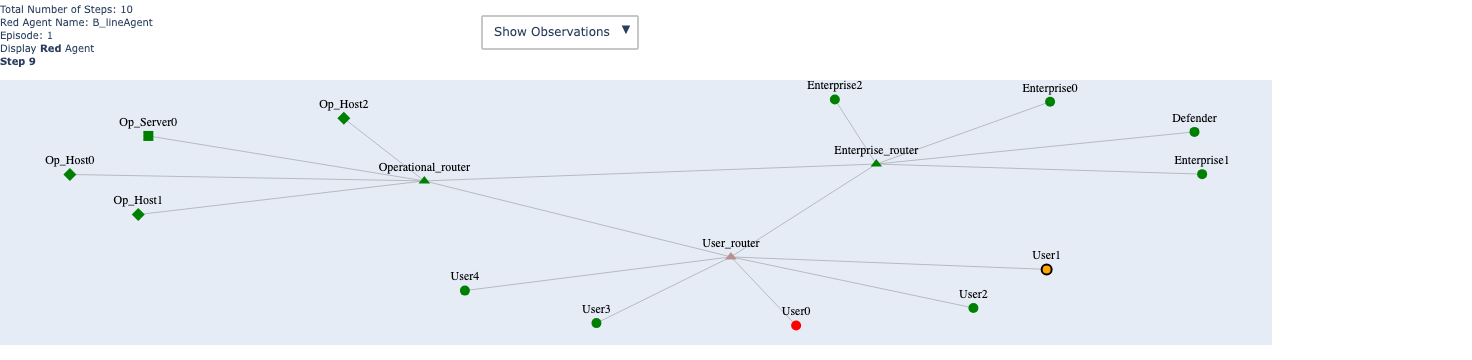

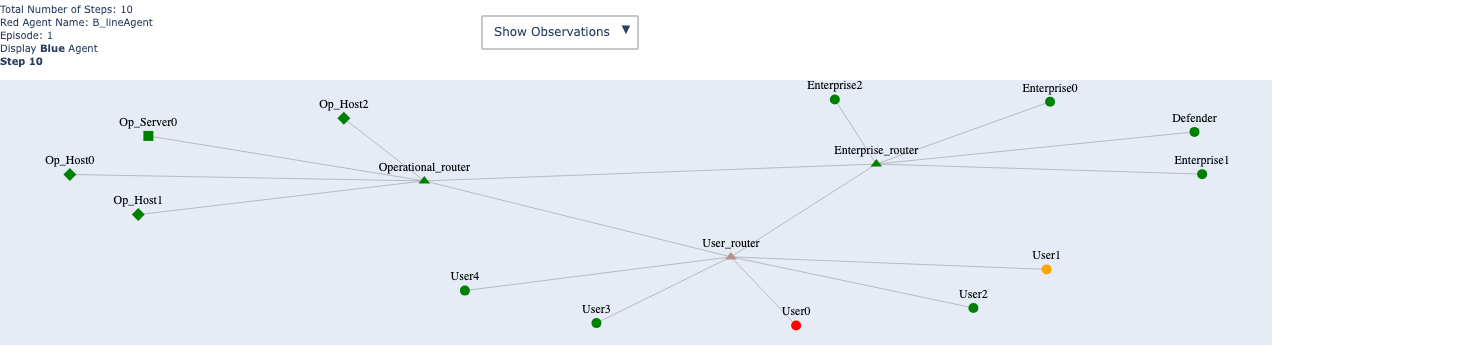

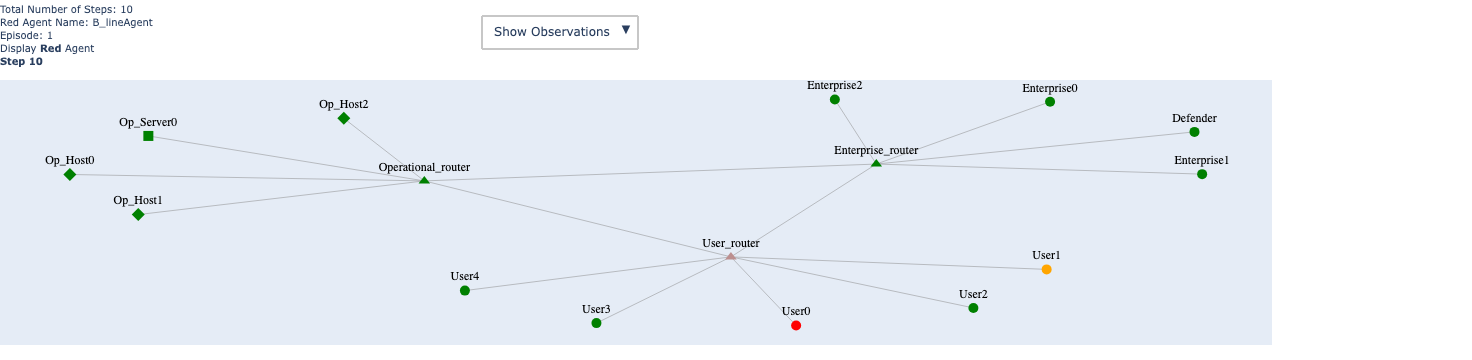

In [7]:
nv = NetworkVisualizer(test_cyborg_minus_minus)
nv.plot(save=False)

In [8]:
def main():
    cyborg_version = CYBORG_VERSION
    scenario = 'Scenario2'
    # commit_hash = get_git_revision_hash()
    commit_hash = "Not using git"
    # ask for a name
    name = "John Hannay"
    # ask for a team
    team = "CardiffUni"
    # ask for a name for the agent
    name_of_agent = "PPO + Greedy decoys"

    lines = inspect.getsource(wrap)
    wrap_line = lines.split('\n')[1].split('return ')[1]

    # Change this line to load your agent
    agent = MainAgent()
    
    print(f'Using agent {agent.__class__.__name__}, if this is incorrect please update the code to load in your agent')

    path = str(inspect.getfile(CybORG))
    path = path[:-7] + f'/Simulator/Scenarios/scenario_files/Scenario2.yaml'
    sg = FileReaderScenarioGenerator(path)

    print(f'using CybORG v{cyborg_version}, {scenario}\n')
    
    # game manager initialization
    game_state_manager = GameStateCollector()
    # mininet adapter initialization
    mininet_adapter = MininetAdapter()
    
    for num_steps in [3]:
        for red_agent in [B_lineAgent]:
            red_agent = red_agent()
            cyborg = CybORG(sg, 'sim', agents={'Red': red_agent})
            wrapped_cyborg = wrap(cyborg)

            observation = wrapped_cyborg.reset()
            # observation = cyborg.reset().observation

            red_agent_name: str = red_agent.__class__.__name__
            blue_agent_name: str = agent.__class__.__name__
            
            # Set up game_state_manager
            game_state_manager.set_environment(cyborg=cyborg,
                                               red_agent_name=red_agent_name,
                                               blue_agent_name=blue_agent_name,
                                               num_steps=num_steps)
            game_state_manager.reset()


            # Reset mininet adapter 
            mininet_adapter.set_environment(cyborg=cyborg)
            mininet_adapter.reset()
            
            action_space = wrapped_cyborg.get_action_space(agent_name)
            # action_space = cyborg.get_action_space(agent_name)
            total_reward = []
            actions = []
            for i in range(MAX_EPS):
                r = []
                a = []
                
                # cyborg.env.env.tracker.render()
                for j in range(num_steps):
                    action = agent.get_action(observation, action_space)
                    observation, rew, done, info = wrapped_cyborg.step(action)
                    print("Observation is:")
                    print(observation)
                    # result = cyborg.step(agent_name, action)
                    r.append(rew)
                    # r.append(result.reward)
                    a.append((str(cyborg.get_last_action('Blue')), str(cyborg.get_last_action('Red'))))
                    
                    # create state for this step
                    state_snapshot = game_state_manager.create_state_snapshot()
                    # The adapter should pass the action as a param
                    obs = mininet_adapter.perform_emulation()
                    # pprint(mininet_adapter)
                    state_snapshot = game_state_manager.update_state_snapshot(state_snapshot, obs)
                    # game manager store state
                    game_state_manager.store_state(state_snapshot, i, j)
                    
                # game manager reset
                agent.end_episode()
                total_reward.append(sum(r))
                actions.append(a)
                # observation = cyborg.reset().observation
                observation = wrapped_cyborg.reset()
                game_state_manager.reset()
                # mininet adapter reset
                mininet_adapter.reset()
        
        mininet_adapter.clean()

    return game_state_manager.get_game_state()

In [13]:
def main_simple_agent():
    cyborg_version = CYBORG_VERSION
    scenario = 'Scenario2'
    # commit_hash = get_git_revision_hash()
    commit_hash = "Not using git"
    # ask for a name
    name = "John Hannay"
    # ask for a team
    team = "CardiffUni"
    # ask for a name for the agent
    name_of_agent = "PPO + Greedy decoys"

    lines = inspect.getsource(wrap)
    wrap_line = lines.split('\n')[1].split('return ')[1]

    # Change this line to load your agent
    agent = BlueReactRemoveAgent()
    
    print(f'Using agent {agent.__class__.__name__}, if this is incorrect please update the code to load in your agent')

    path = str(inspect.getfile(CybORG))
    path = path[:-7] + f'/Simulator/Scenarios/scenario_files/Scenario2.yaml'

    sg = FileReaderScenarioGenerator(path)

    print(f'using CybORG v{cyborg_version}, {scenario}\n')
    
    # game manager initialization
    game_state_manager = GameStateCollector()
    # mininet adapter initialization
    mininet_adapter = MininetAdapter()

    
    for num_steps in [5]:
        for red_agent in [B_lineAgent]:
            red_agent = red_agent()
            cyborg = CybORG(sg, 'emu', agents={'Red': red_agent})

            observation = cyborg.reset()
            # print('observation is:',observation)
            
            # Rest set up game_state_manager
            game_state_manager.set_environment(cyborg=cyborg,
                                               red_agent=red_agent,
                                               blue_agent=agent,
                                               num_steps=num_steps)
            game_state_manager.reset()


            # Reset mininet adapter 
            mininet_adapter.set_environment(cyborg=cyborg)
            mininet_adapter.reset()
            
            
            action_space = cyborg.get_action_space(agent_name)

            total_reward = []
            actions = []
            for i in range(MAX_EPS):
                r = []
                a = []
                
                # cyborg.env.env.tracker.render()
                for j in range(num_steps):
                    blue_action_space = cyborg.get_action_space('Blue')
                    blue_obs = cyborg.get_observation('Blue') # get the newest observation
                    blue_action = agent.get_action(blue_obs, blue_action_space)
                    # pprint(blue_action)
                    print("Observation is:")
                    print(blue_obs)
                    result = cyborg.step('Blue', blue_action, skip_valid_action_check=False)
                    
                    # create state for this step
                    state_snapshot = game_state_manager.create_state_snapshot()
                    
                    # The adapter should pass the action as a param
                    obs = mininet_adapter.perform_emulation()
                    # pprint(mininet_adapter)
                    state_snapshot = game_state_manager.update_state_snapshot(state_snapshot, obs)
                    

                    # game manager store state
                    game_state_manager.store_state(state_snapshot, i, j)


                    
                # game manager reset
                agent.end_episode()
                total_reward.append(sum(r))
                actions.append(a)
                # observation = cyborg.reset().observation
                observation = cyborg.reset()
                # game state manager reset
                game_state_manager.reset()
                # mininet adapter reset
                mininet_adapter.reset()
        
        mininet_adapter.clean()

    return game_state_manager.get_game_state()

In [14]:
# %%capture
game_state_simple = main_simple_agent()


Using agent BlueReactRemoveAgent, if this is incorrect please update the code to load in your agent
using CybORG v3.1, Scenario2

env is: emu
Agent Interfaces are: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f020f4b3130>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f020f4b2980>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f020fb9cc70>}
===Resetting===
Topology for file 'network_topology.yaml' created.
YAML file 'network_topology.yaml' created.
 lan1h1 ping -c 1 google.com
PING google.com (142.251.15.113) 56(84) bytes of data.
64 bytes from yl-in-f113.1e100.net (142.251.15.113): icmp_seq=1 ttl=53 time=12.4 ms

--- google.com ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 12.410/12.410/12.410/0.000 ms

Observation is:
{'success': <TrinaryEnum.UNKNOWN: 2>, 'Defender': {'Interface': [{'Interface Name': 'eth0', 'IP Address': IPv4Address('10.0.37.78'), 'Subnet': IPv4Netw

In [14]:
# game_state_simple

In [15]:
# nv = NetworkVisualizer(game_state_simple)
# nv.plot(save=False)

In [10]:
# %%capture
game_state_pretained = main()

Using agent MainAgent, if this is incorrect please update the code to load in your agent
using CybORG v3.1, Scenario2

env is: sim
Agent Interfaces are: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f020f9f8610>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f020fc90a60>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f020fc6da50>}
Agent Interfaces are: {'Blue': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f020faca320>, 'Green': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f020faca110>, 'Red': <CybORG.Shared.AgentInterface.AgentInterface object at 0x7f020facaaa0>}
===Resetting===
Topology for file 'network_topology.yaml' created.
YAML file 'network_topology.yaml' created.
 lan1h1 ping -c 1 google.com
ping: google.com: Temporary failure in name resolution

---> In Challenge Wrapper
51
--> In BaseWrapper
DecoyApache Enterprise0
action is: {'Blue': DecoyApache Enterprise0}
In SimulationController script


In [16]:
# nv = NetworkVisualizer(game_state_pretained)
# nv.plot(save=False)

In [17]:
# animation

# router blink
# surrond any change icon with dashlines(happnening this steps)

### Notes

1. Try scaling up the scenarios: 10,000 nodes

2. html panel / information panel / controller of the game which does animation (live/historical)


